# Entendimento geral sobre regressão 

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm

from sklearn.datasets import load_boston

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler

In [68]:
def corrplot(data, vmin= -1, vmax= 1, figsize=(10,7)):
    """Gráfico de correlação com paleta de cores do azul ao vermelho e anotações para melhor entendimento dos dados

    Args:
        data (pd.DataFrame): base de dados para realizar a correlação
        vmin (int, optional): valos mínimo de correlação. Defaults to -1.
        vmax(int, optional): valor máximo de correlação. Defaults to 1.

    Returns:
        sns.heatmap: impressão do gráfico
    """      
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=figsize)

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(data = data.corr(), 
                cmap = cmap, 
                vmin = vmin, 
                vmax = vmax,
                annot=True)

    return plt.show()

In [69]:
def norm_test(df, type='Kolmorogov'):
    """Realiza teste de normalidade de Kolmorogov no resíduo da previsão
    Args:
        df (pd.Series): resíduo da previsão
    Returns:
        data(pd.DataFrame): tabela com as informações estatísticas e P-Value do resíduo de previsão
    """ 
    from scipy import stats
    import pandas as pd
      
    
    if type == 'Kolmorogov':
        normKol = stats.kstest(df, 'norm')
        
        Stat, Pvalue = normKol
        data = pd.DataFrame({'Stat': Stat,
                             'P-Value': Pvalue},
                             index=[type]).round(decimals=5)
        
    elif type == 'Shapiro':
        normShap = stats.shapiro(df)
        
        Stat = normShap.statistic
        Pvalue = normShap.pvalue
        data = pd.DataFrame({'Stat': Stat,
                             'P-Value': Pvalue},
                             index=[type]).round(decimals=5)
        
    elif type == 'DAgostino':
        normDag = stats.normaltest(df)
        
        Stat = normDag.statistic
        Pvalue = normDag.pvalue
        data = pd.DataFrame({'Stat': Stat,
                             'P-Value': Pvalue},
                             index=[type]).round(decimals=5)
        
    elif type =='all':
        normKol = stats.kstest(df, 'norm')
        normShap = stats.shapiro(df)
        normDag = stats.normaltest(df)
        
        kStat, kPvalue = normKol
        sStat = normShap.statistic
        sPvalue = normShap.pvalue
        dStat = normDag.statistic
        dPvalue = normDag.pvalue
        data = pd.DataFrame({'Stat': [kStat, sStat, dStat],
                             'P-Value': [kPvalue, sPvalue, dPvalue]},
                             index=['Kolmorogov', 'Shapiro', 'DAgostino']).round(decimals=5)

    return data

In [70]:
def predict_table(y, y_pred, columns=['Real', 'Previsto'], residual=False):
    """Tabela de previsão e cálculo de resíduo do modelo

    Args:
        y (pd.DataFrame): variável resposta
        fit (.predict): predição do modelo ajustado dos regressores
        columns (list): nome das colunas Real e Previsto
        residual (bool, optional): cálculo do residual dos regressores. Defaults to False.

    Returns:
        pred(pd.DataFrame): base com predição do modelo ajustado
    """  
    
    import pandas as pd
    
    pred = pd.concat([y, pd.DataFrame(y_pred)], axis=1)
    pred.columns = columns

    if residual is True:
        pred['Res'] = pred[columns[0]] - pred[columns[1]]

    return pred

In [71]:
def adj_quality(pred, index, form=False, reg=None):
    """Qualidade de ajuste do modelo com R² e RMSE

    Args:
        pred (pd.DataFrame): tabela de previsão do modelo

    Returns:
        adj(pd.DataFrame): cálculo de R² e RMSE do modelo
    """    
    import pandas as pd
    import numpy as np
    from sklearn import metrics
    
    pred.columns = ['Real', 'Previsto']

    
    if form is True:
        fo = "y = {} + {} x".format(reg.intercept_, reg.coef_[0])
        adj = pd.DataFrame({
        'R²': metrics.r2_score(pred.loc[:, pred.columns[0]], 
                               pred.loc[:, pred.columns[1]]),
        'MSE': metrics.mean_squared_error(pred.loc[:, pred.columns[0]], 
                                          pred.loc[:, pred.columns[1]]),
        'RMSE': np.sqrt(metrics.mean_squared_error(pred.loc[:, pred.columns[0]], 
                                                   pred.loc[:, pred.columns[1]]))
        }, index=[index])
        
        return adj.round(decimals=3), fo
    
    else:
        adj = pd.DataFrame({
            'R²': metrics.r2_score(pred['Real'], 
                                   pred['Previsto']),
            'MSE': metrics.mean_squared_error(pred['Real'], 
                                              pred['Previsto']),
            'RMSE': metrics.mean_squared_error(pred['Real'], 
                                               pred['Previsto'], squared=False),
            'RMSLE': metrics.mean_squared_log_error(pred.loc[pred['Previsto'] > 0, ['Real']], 
                                                    pred.loc[pred['Previsto'] > 0, ['Previsto']]),
            'MAE': metrics.mean_absolute_error(pred['Real'], 
                                               pred['Previsto'])
        }, index=[index])
        
        return adj.round(decimals=3)

## Fish Market

### Descrição dos dados

Feature | Descrição | Range | Tipo
:------ | :-------- | :---: | :---:
Species | Espécie de peixe | 7 | Object
Weight  | Peso do peixe (g) | 0.00 - 1650 | Target
Length1 | Comprimento vertical do peixe (cm) | 7.50 - 59.0 | Numérico
Length2 | Comprimento diagonal do peixe (cm) | 8.40 - 63.4 | Numérico
Length3 | Comprimento transversal do peixe (cm) | 8.80 - 68.0 | Numérico
Height  | Altura do peixe (cm) | 1.728 - 18.96 | Numérico
Width   | Largura diagonal do peixe | 1.05 - 8.14 | Numérico

In [72]:
df = pd.read_csv('https://raw.githubusercontent.com/bruna-calistrate/Regression-SupervisedModels-Course/main/dataset/Fish.csv')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [74]:
df.describe(include='all', percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,unique,top,freq,mean,std,min,5%,25%,50%,75%,90%,99%,max
Species,159,7,Perch,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,159.0,NaN,NaN,NaN,398.326415,357.978317,0.0,9.8,120.0,273.0,650.0,930.0,1571.0,1650.0
Length1,159.0,NaN,NaN,NaN,26.24717,9.996441,7.5,11.3,19.05,25.2,32.7,38.2,56.0,59.0
Length2,159.0,NaN,NaN,NaN,28.415723,10.716328,8.4,11.8,21.0,27.3,35.5,41.2,60.0,63.4
Length3,159.0,NaN,NaN,NaN,31.227044,11.610246,8.8,13.1,23.15,29.4,39.65,45.34,64.0,68.0
Height,159.0,NaN,NaN,NaN,8.970994,4.286208,1.7284,2.20356,5.9448,7.786,12.3659,15.1904,18.685296,18.957
Width,159.0,NaN,NaN,NaN,4.417486,1.685804,1.0476,1.28314,3.38565,4.2485,5.5845,6.7421,7.679758,8.142


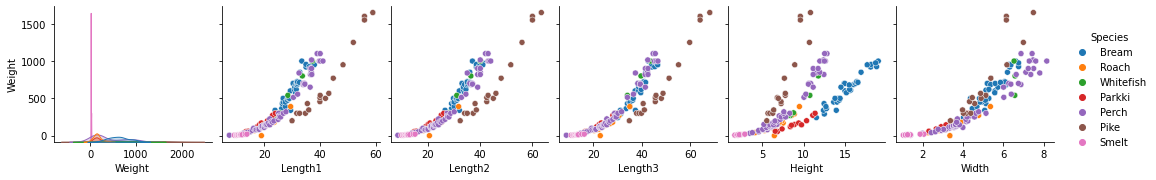

In [75]:
sns.pairplot(data=df, y_vars='Weight', hue='Species')

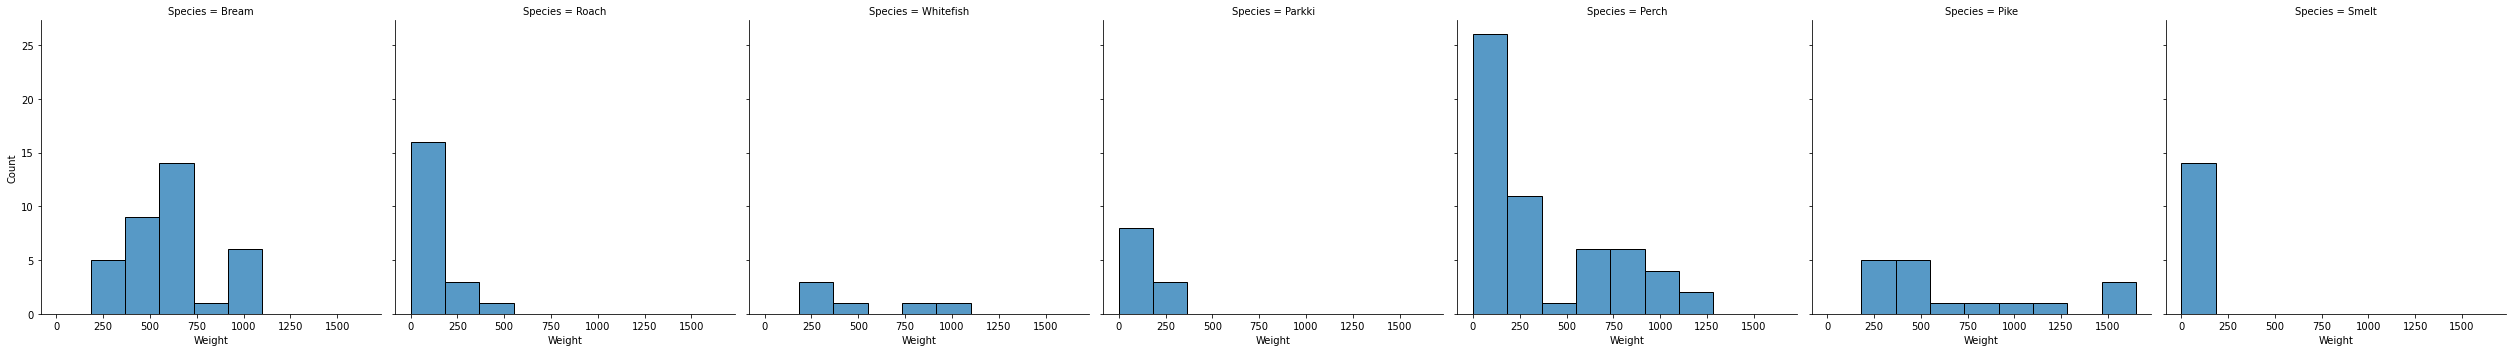

In [76]:
sns.displot(data=df, x='Weight', col='Species',
            kind='hist')

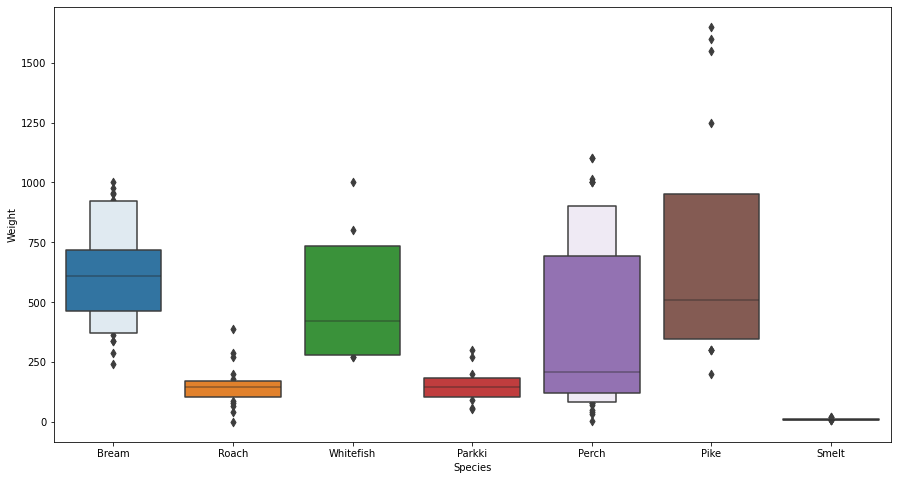

In [77]:
plt.figure(figsize=(15,8))
sns.boxenplot(data=df, y='Weight', x='Species')
plt.show()

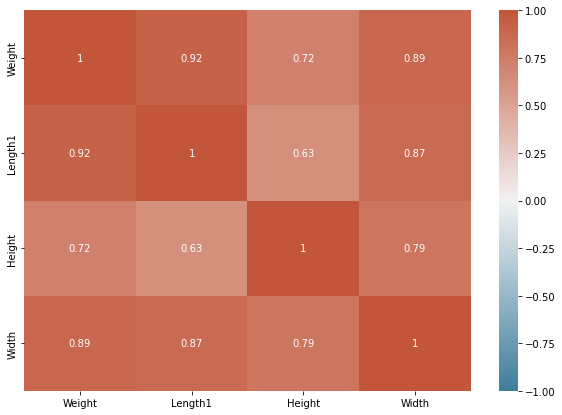

In [78]:
corrplot(df.drop(columns=['Length2', 'Length3']))

### Transformação dos dados categóricos

In [79]:
dfs = pd.get_dummies(df['Species'], prefix='Species_')
df = pd.concat([df, dfs], axis=1)
df.drop(columns=['Species'], inplace=True)
df.head()

,Weight,Length1,Length2,Length3,Height,Width,Species__Bream,Species__Parkki,Species__Perch,Species__Pike,Species__Roach,Species__Smelt,Species__Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0


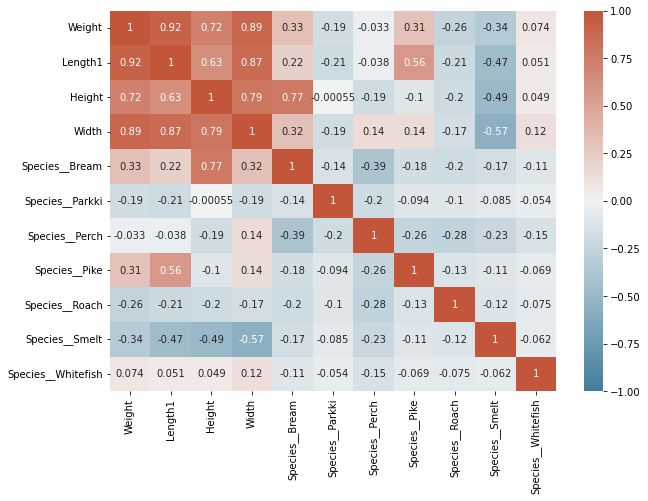

In [80]:
corrplot(df.drop(columns=['Length2', 'Length3']))

### Dividir o dataset

In [81]:
y = df['Weight']
x = df.drop(columns=['Weight', 'Length2', 'Length3'])

In [82]:
x_Train, x_Test, y_Train, y_Test = train_test_split(x, y, test_size=0.2, random_state=42)

data = (x_Train, x_Test, y_Train, y_Test)

for d in data:
    d.reset_index(drop=True, inplace=True)

### Normalização dos dados numéricos

* Logarítmica
* Raiz quadrada
* Raiz cúbica

In [83]:
num = ['Length1', 'Height', 'Width']
cat = ['Species__Bream', 'Species__Parkki', 'Species__Perch', 'Species__Pike', 'Species__Roach', 'Species__Smelt', 'Species__Whitefish']

In [84]:
x_Train_log = pd.concat([np.log(x_Train[num]), x_Train[cat]], axis=1)
x_Train_sqrt = pd.concat([np.sqrt(x_Train[num]), x_Train[cat]], axis=1)
x_Train_cbrt = pd.concat([np.cbrt(x_Train[num]), x_Train[cat]], axis=1)

x_Test_log = pd.concat([np.log(x_Test[num]), x_Test[cat]], axis=1)
x_Test_sqrt = pd.concat([np.sqrt(x_Test[num]), x_Test[cat]], axis=1)
x_Test_cbrt = pd.concat([np.cbrt(x_Test[num]), x_Test[cat]], axis=1)

In [85]:
x_Train_log.head()

,Length1,Height,Width,Species__Bream,Species__Parkki,Species__Perch,Species__Pike,Species__Roach,Species__Smelt,Species__Whitefish
0,2.708050,1.524403,0.967592,0,0,1,0,0,0,0
1,3.765840,2.053098,1.583094,0,0,0,1,0,0,0
2,3.173878,2.515905,1.546732,1,0,0,0,0,0,0
3,2.995732,1.809927,1.225979,0,0,1,0,0,0,0
4,3.020425,1.950670,1.340329,0,0,0,0,1,0,0


In [86]:
x_Train_sqrt.head()

,Length1,Height,Width,Species__Bream,Species__Parkki,Species__Perch,Species__Pike,Species__Roach,Species__Smelt,Species__Whitefish
0,3.872983,2.142989,1.622221,0,0,1,0,0,0,0
1,6.572671,2.791415,2.206808,0,0,0,1,0,0,0
2,4.888763,3.518210,2.167049,1,0,0,0,0,0,0
3,4.472136,2.471841,1.845941,0,0,1,0,0,0,0
4,4.527693,2.652056,1.954559,0,0,0,0,1,0,0


In [87]:
x_Train_cbrt.head()

,Length1,Height,Width,Species__Bream,Species__Parkki,Species__Perch,Species__Pike,Species__Roach,Species__Smelt,Species__Whitefish
0,2.466212,1.662187,1.380617,0,0,1,0,0,0,0
1,3.508821,1.982514,1.695026,0,0,0,1,0,0,0
2,2.880487,2.313207,1.674605,1,0,0,0,0,0,0
3,2.714418,1.828158,1.504799,0,0,1,0,0,0,0
4,2.736852,1.915969,1.563265,0,0,0,0,1,0,0


### Treinamento e validação de modelos

In [88]:
train = [x_Train, x_Train_log, x_Train_sqrt, x_Train_cbrt]
test = [x_Test, x_Test_log, x_Test_sqrt, x_Test_cbrt]
index = ['Não tratados', 'Logaritmica', 'Raiz Quadrada', 'Raiz cúbica']

In [89]:
adj_table = pd.DataFrame(columns=['R²','MSE','RMSE','RMSLE','MAE'])
for tr, te, ind in zip(train, test, index):

    reg = LinearRegression().fit(tr, y_Train)

    y_pred = reg.predict(te)
    adj_table = pd.concat([adj_table,adj_quality(predict_table(y_Test, y_pred), index=ind)], axis=0)

predLinear = predict_table(y_Test, reg.predict(x_Test), residual=True)

adj_table
    

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,0.941,8431.409,91.823,0.278,68.478
Logaritmica,0.857,20336.446,142.606,0.102,112.693
Raiz Quadrada,0.903,13733.690,117.191,0.204,90.888
Raiz cúbica,0.890,15612.284,124.949,0.146,98.031


In [90]:
adj_table = pd.DataFrame(columns=['R²','MSE','RMSE','RMSLE','MAE'])
for tr, te, ind in zip(train, test, index):

    reg = Lasso().fit(tr, y_Train)

    y_pred = reg.predict(te)
    adj_table = pd.concat([adj_table,adj_quality(predict_table(y_Test, y_pred), index=ind)], axis=0)

adj_table

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,0.944,7926.681,89.032,0.142,69.673
Logaritmica,0.848,21575.964,146.888,0.501,117.092
Raiz Quadrada,0.904,13589.303,116.573,0.115,94.498
Raiz cúbica,0.885,16404.504,128.080,0.102,103.641


In [91]:
adj_table = pd.DataFrame(columns=['R²','MSE','RMSE','RMSLE','MAE'])
for tr, te, ind in zip(train, test, index):

    reg = Ridge().fit(tr, y_Train)

    y_pred = reg.predict(te)
    adj_table = pd.concat([adj_table,adj_quality(predict_table(y_Test, y_pred), index=ind)], axis=0)

adj_table

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,0.945,7855.155,88.629,0.087,70.179
Logaritmica,0.838,23083.877,151.934,0.128,121.962
Raiz Quadrada,0.904,13641.133,116.795,0.087,94.675
Raiz cúbica,0.880,17086.016,130.713,0.211,104.428


In [92]:
adj_table = pd.DataFrame(columns=['R²','MSE','RMSE','RMSLE','MAE'])
for tr, te, ind in zip(train, test, index):

    reg = SGDRegressor().fit(tr, y_Train)

    y_pred = reg.predict(te)
    adj_table = pd.concat([adj_table,adj_quality(predict_table(y_Test, y_pred), index=ind)], axis=0)

adj_table

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,-4.345591e+13,6.181137e+18,2.486189e+09,270.128,1.528998e+09
Logaritmica,7.140000e-01,4.063541e+04,2.015820e+02,0.267,1.689620e+02
Raiz Quadrada,6.640000e-01,4.782558e+04,2.186910e+02,1.141,1.840880e+02
Raiz cúbica,5.390000e-01,6.563471e+04,2.561930e+02,1.332,2.058940e+02


In [93]:
adj_table = pd.DataFrame(columns=['R²','MSE','RMSE','RMSLE','MAE'])
for tr, te, ind in zip(train, test, index):

    reg = RandomForestRegressor(max_depth=5).fit(tr, y_Train)

    y_pred = reg.predict(te)
    adj_table = pd.concat([adj_table,adj_quality(predict_table(y_Test, y_pred), index=ind)], axis=0)

adj_table

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,0.961,5578.257,74.688,0.037,52.996
Logaritmica,0.957,6114.937,78.198,0.036,53.923
Raiz Quadrada,0.964,5142.946,71.714,0.036,51.021
Raiz cúbica,0.957,6153.368,78.443,0.041,54.918


In [94]:
adj_table = pd.DataFrame(columns=['R²','MSE','RMSE','RMSLE','MAE'])
for tr, te, ind in zip(train, test, index):

    reg = AdaBoostRegressor(random_state=0, n_estimators=100).fit(tr, y_Train)

    y_pred = reg.predict(te)
    adj_table = pd.concat([adj_table,adj_quality(predict_table(y_Test, y_pred), index=ind)], axis=0)

adj_table

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,0.943,8057.782,89.765,0.597,68.632
Logaritmica,0.938,8755.351,93.570,0.600,71.989
Raiz Quadrada,0.938,8839.154,94.017,0.524,70.404
Raiz cúbica,0.942,8245.828,90.807,0.529,69.713


In [95]:
adj_table = pd.DataFrame(columns=['R²','MSE','RMSE','RMSLE','MAE'])
for tr, te, ind in zip(train, test, index):

    reg = GradientBoostingRegressor(random_state=0, n_estimators=100).fit(tr, y_Train)

    y_pred = reg.predict(te)
    adj_table = pd.concat([adj_table,adj_quality(predict_table(y_Test, y_pred), index=ind)], axis=0)

adj_table

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,0.959,5800.937,76.164,0.035,51.014
Logaritmica,0.959,5845.069,76.453,0.035,50.944
Raiz Quadrada,0.959,5845.069,76.453,0.035,50.944
Raiz cúbica,0.959,5845.069,76.453,0.035,50.944


In [96]:
adj_table = pd.DataFrame(columns=['R²','MSE','RMSE','RMSLE','MAE'])
for tr, te, ind in zip(train, test, index):

    reg = ExtraTreesRegressor(random_state=0, n_estimators=100).fit(tr, y_Train)

    y_pred = reg.predict(te)
    adj_table = pd.concat([adj_table,adj_quality(predict_table(y_Test, y_pred), index=ind)], axis=0)

adj_table

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,0.979,2924.398,54.078,0.015,37.219
Logaritmica,0.976,3433.919,58.600,0.015,38.605
Raiz Quadrada,0.977,3284.455,57.310,0.016,38.861
Raiz cúbica,0.976,3343.162,57.820,0.015,39.230


### Análise de resíduos

In [97]:
reg = LinearRegression().fit(x_Train, y_Train)
y_pred = reg.predict(x_Test)
predLinear = predict_table(y_Test, y_pred, residual=True)

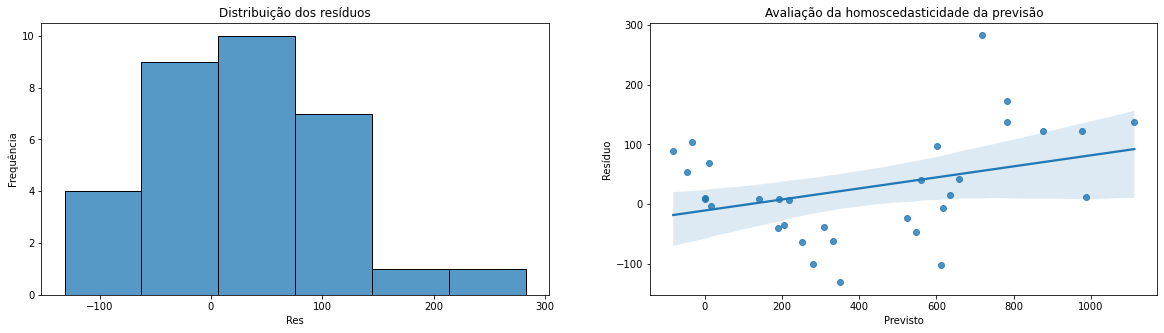

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

sns.histplot(data=predLinear, x='Res', ax=axes[0]).set_ylabel('Frequência')
axes[0].set_title('Distribuição dos resíduos')

sns.regplot(data=predLinear, x='Previsto', y='Res', ax=axes[1]).set_ylabel('Resíduo')
axes[1].set_title('Avaliação da homoscedasticidade da previsão')

plt.show()

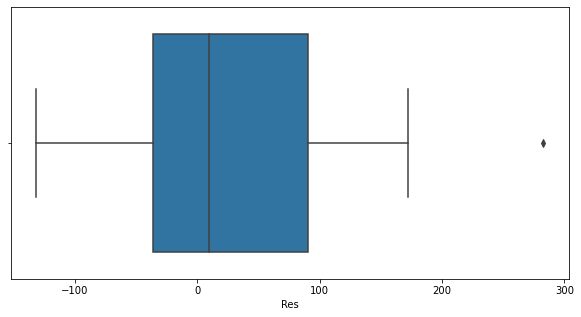

In [100]:
plt.figure(figsize=(10, 5))

sns.boxplot(data=predLinear,
            x='Res')


plt.show()

## Body Fat Prediction
### Descrição dos dados

Feature | Descrição                               | Range           | Tipo
:------ | :--------                               | :---:           | :----:
Density | Densidade pesada debaixo d'água         | 0.995 - 1.109   | Numérica
BodyFat | Percentual da gordura corporal          | 0.00 - 47.5     | Target
Age     | Idade                                   | 22 - 81         | Numérica
Weight  | Peso                              (lbs) | 118.50 - 363.15 | Numérica
Height  | Altura                            (pol) | 29.50 - 77.75   | Numérica
Neck    | Circunferência do pescoço          (cm) | 31.1 - 51.2     | Numérica
Chest   | Circunferência do tórax            (cm) | 79.30 - 136.2   | Numérica
Abdomen | Circunferência do abdomen          (cm) | 69.40 - 148.1   | Numérica
Hip     | Circunferência da quadril          (cm) | 85.00 - 147.7   | Numérica
Thigh   | Circunferência da coxa             (cm) | 47.20 - 87.30   | Numérica
Knee    | Circunferência do joelho           (cm) | 33.00 - 49.10   | Numérica
Ankle   | Circunferência do tornozelo        (cm) | 19.10 - 33.90   | Numérica
Biceps  | Circunferência do bíceps extendido (cm) | 24.8 - 45.0     | Numérica
Forearm | Circunferência do antebraço        (cm) | 21.0 - 34.9     | Numérica
Wrist   | Circunferência do pulso            (cm) | 15.8 - 21.4     | Numérica


In [101]:
df = pd.read_csv('https://raw.githubusercontent.com/bruna-calistrate/Regression-SupervisedModels-Course/main/dataset/bodyfat.csv')
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB


In [103]:
df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
Density,252.0,1.055574,0.019031,0.995,1.02571,1.0414,1.0549,1.0704,1.07996,1.095393,1.1089
BodyFat,252.0,19.150794,8.368740,0.000,6.05500,12.4750,19.2000,25.3000,29.99000,36.621000,47.5000
Age,252.0,44.884921,12.602040,22.000,25.00000,35.7500,43.0000,54.0000,62.90000,72.000000,81.0000
Weight,252.0,178.924405,29.389160,118.500,136.38750,159.0000,176.5000,197.0000,216.92500,245.720000,363.1500
Height,252.0,70.148810,3.662856,29.500,65.88750,68.2500,70.0000,72.2500,73.75000,76.000000,77.7500
Neck,252.0,37.992063,2.430913,31.100,34.25500,36.4000,38.0000,39.4250,40.90000,42.996000,51.2000
Chest,252.0,100.824206,8.430476,79.300,89.02000,94.3500,99.6500,105.3750,112.24000,120.733000,136.2000
Abdomen,252.0,92.555952,10.783077,69.400,76.87500,84.5750,90.9500,99.3250,105.68000,120.009000,148.1000
Hip,252.0,99.904762,7.164058,85.000,89.15500,95.5000,99.3000,103.5250,108.78000,115.794000,147.7000
Thigh,252.0,59.405952,5.249952,47.200,51.15500,56.0000,59.0000,62.3500,65.98000,72.696000,87.3000


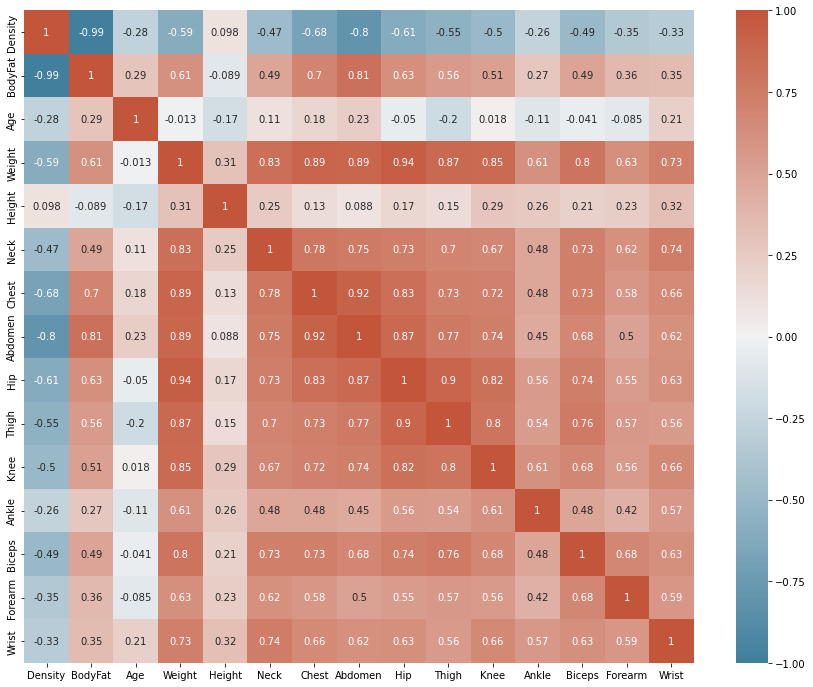

In [104]:
corrplot(df, figsize=(15,12))

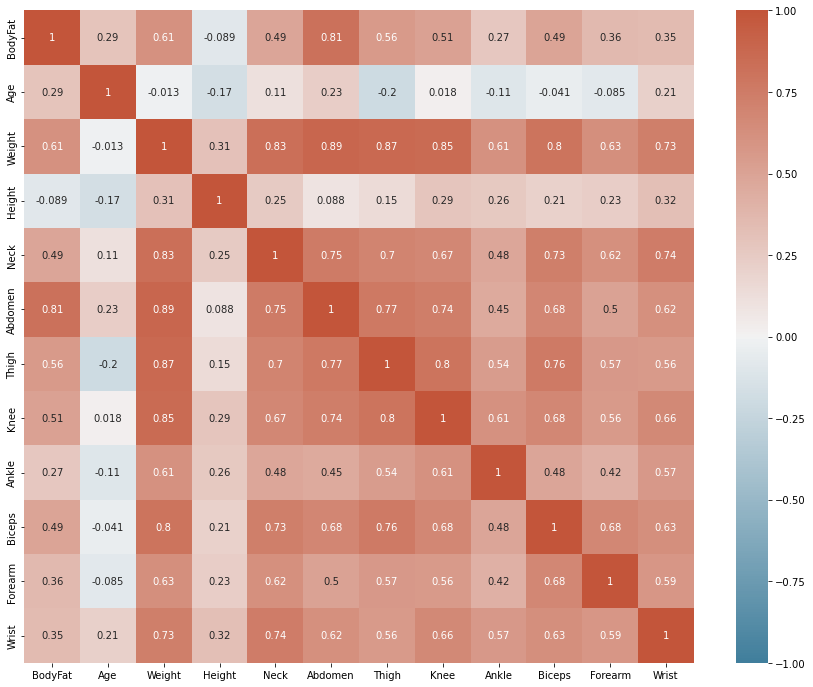

In [105]:
df.drop(columns=['Chest', 'Hip', 'Density'], inplace=True)
corrplot(df, figsize=(15,12))

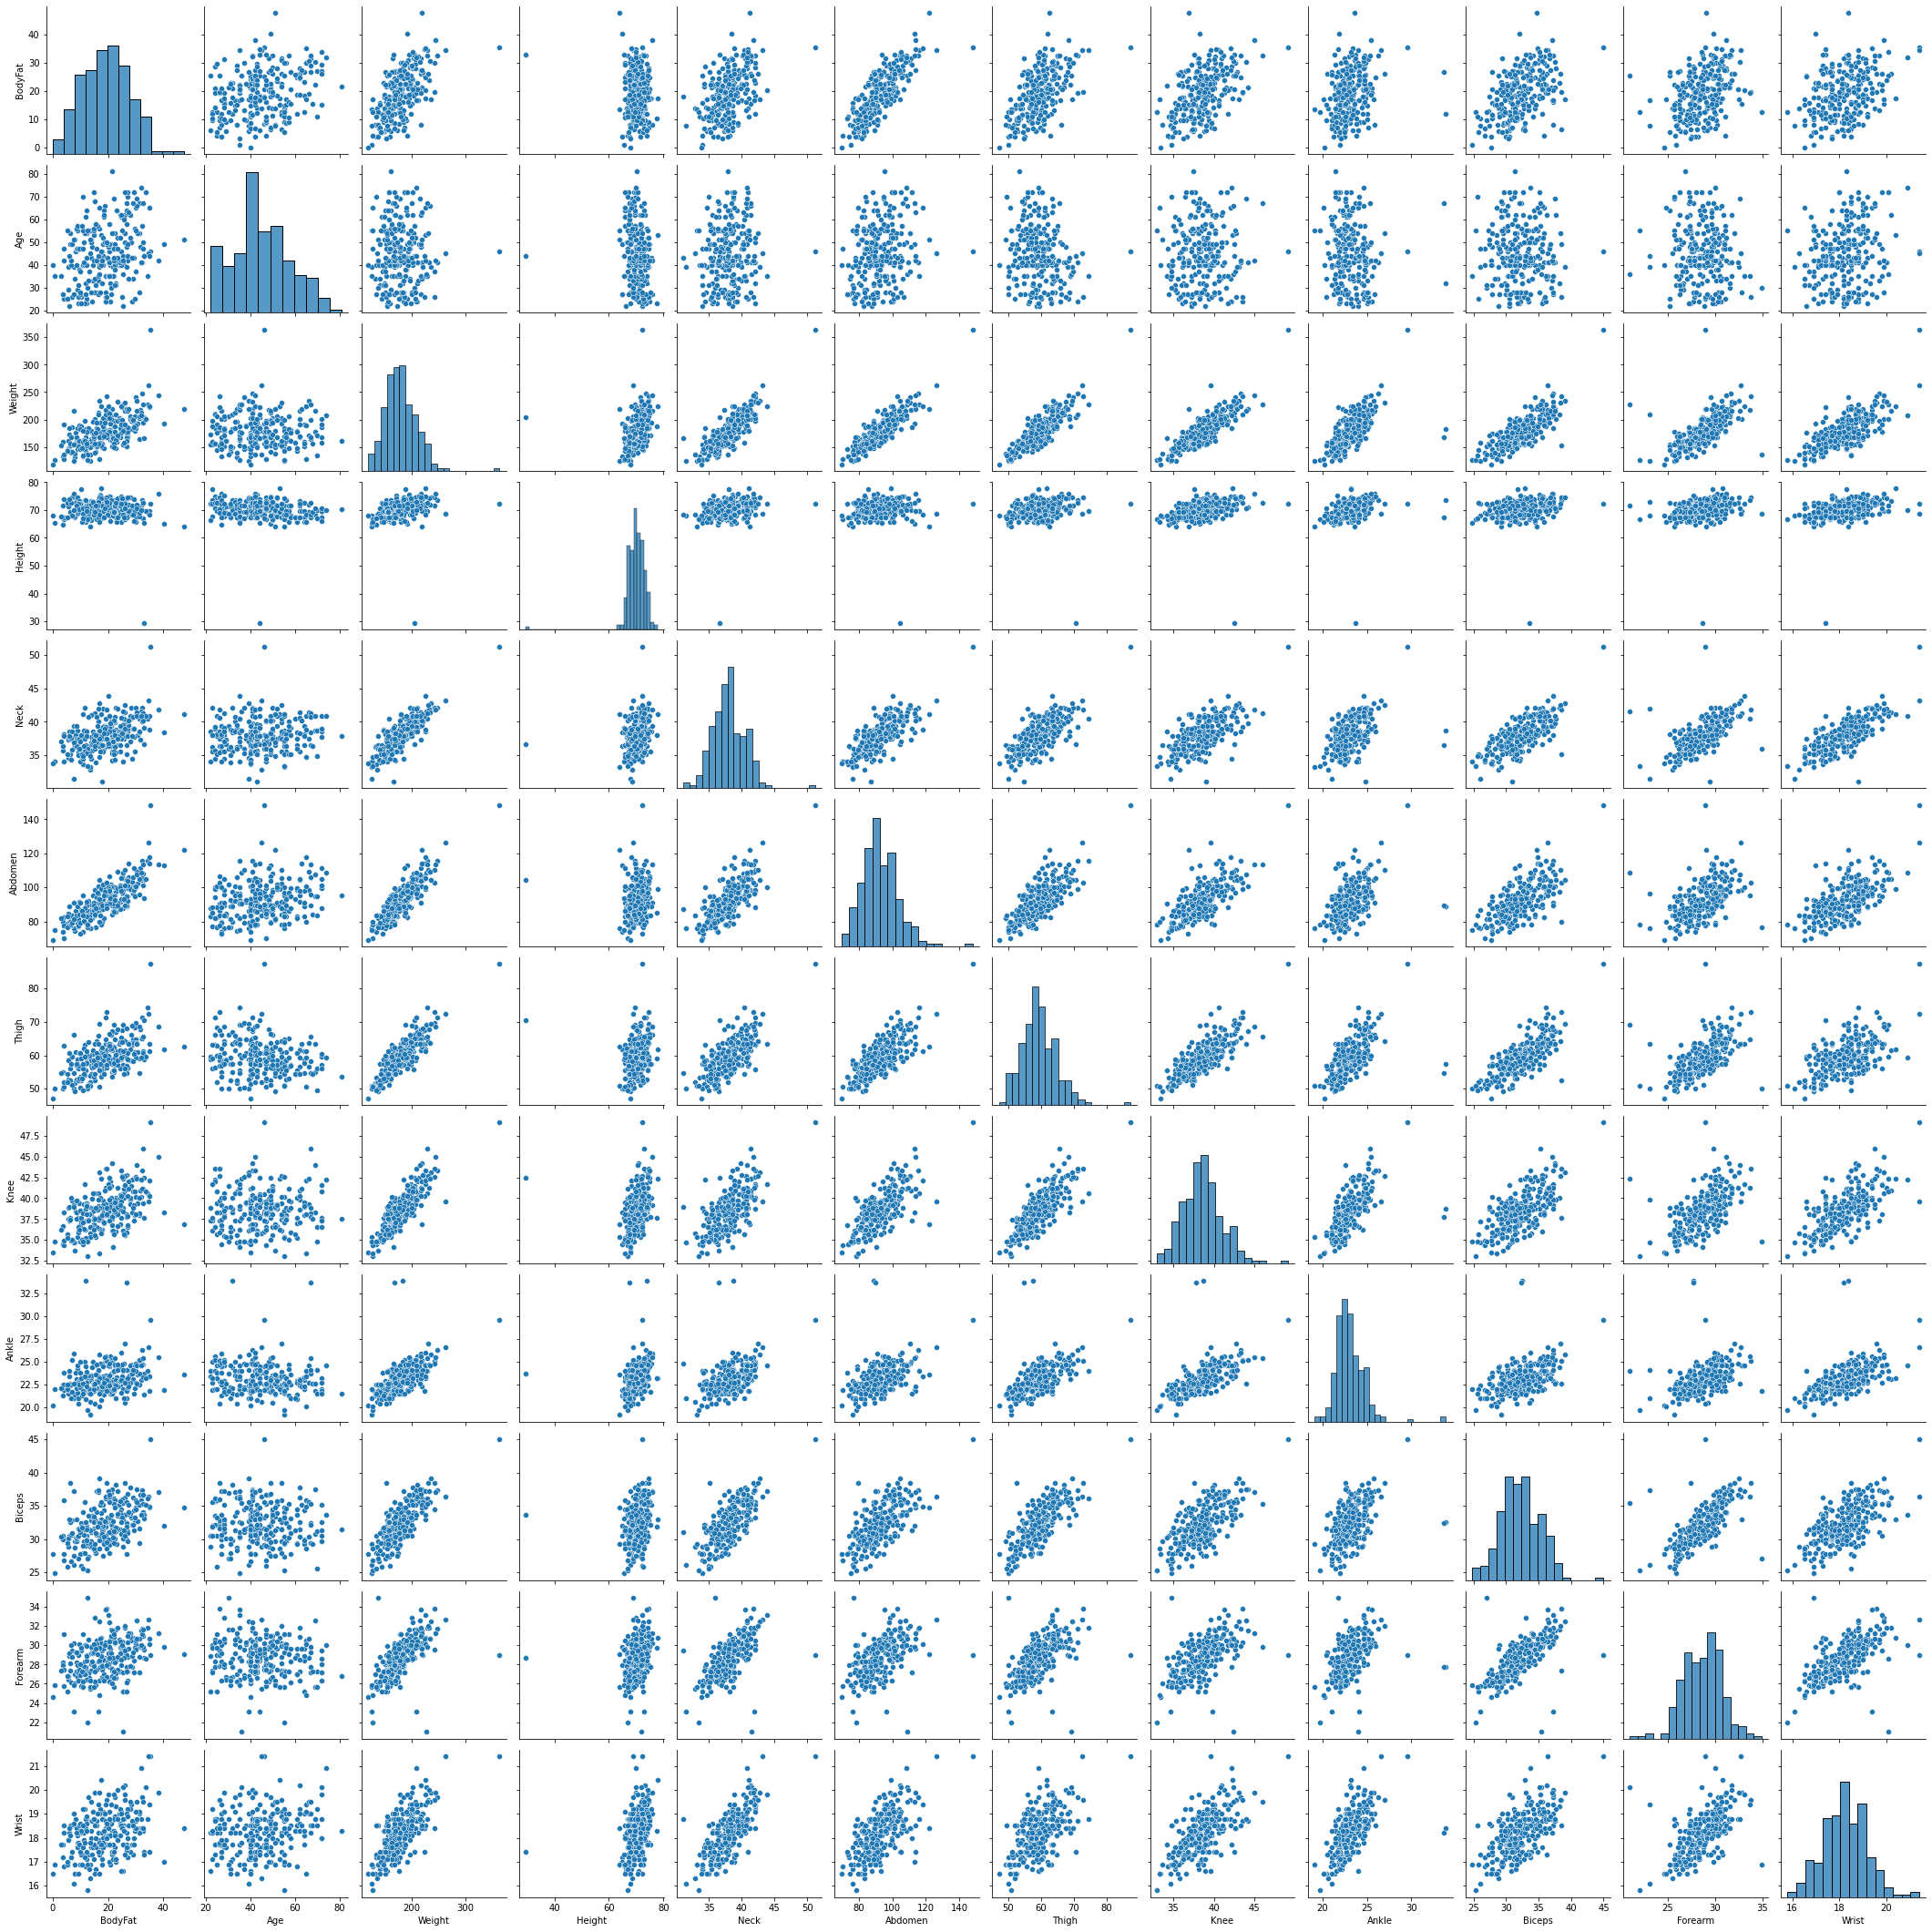

In [106]:
sns.pairplot(df)

In [107]:
df.shape

(252, 12)

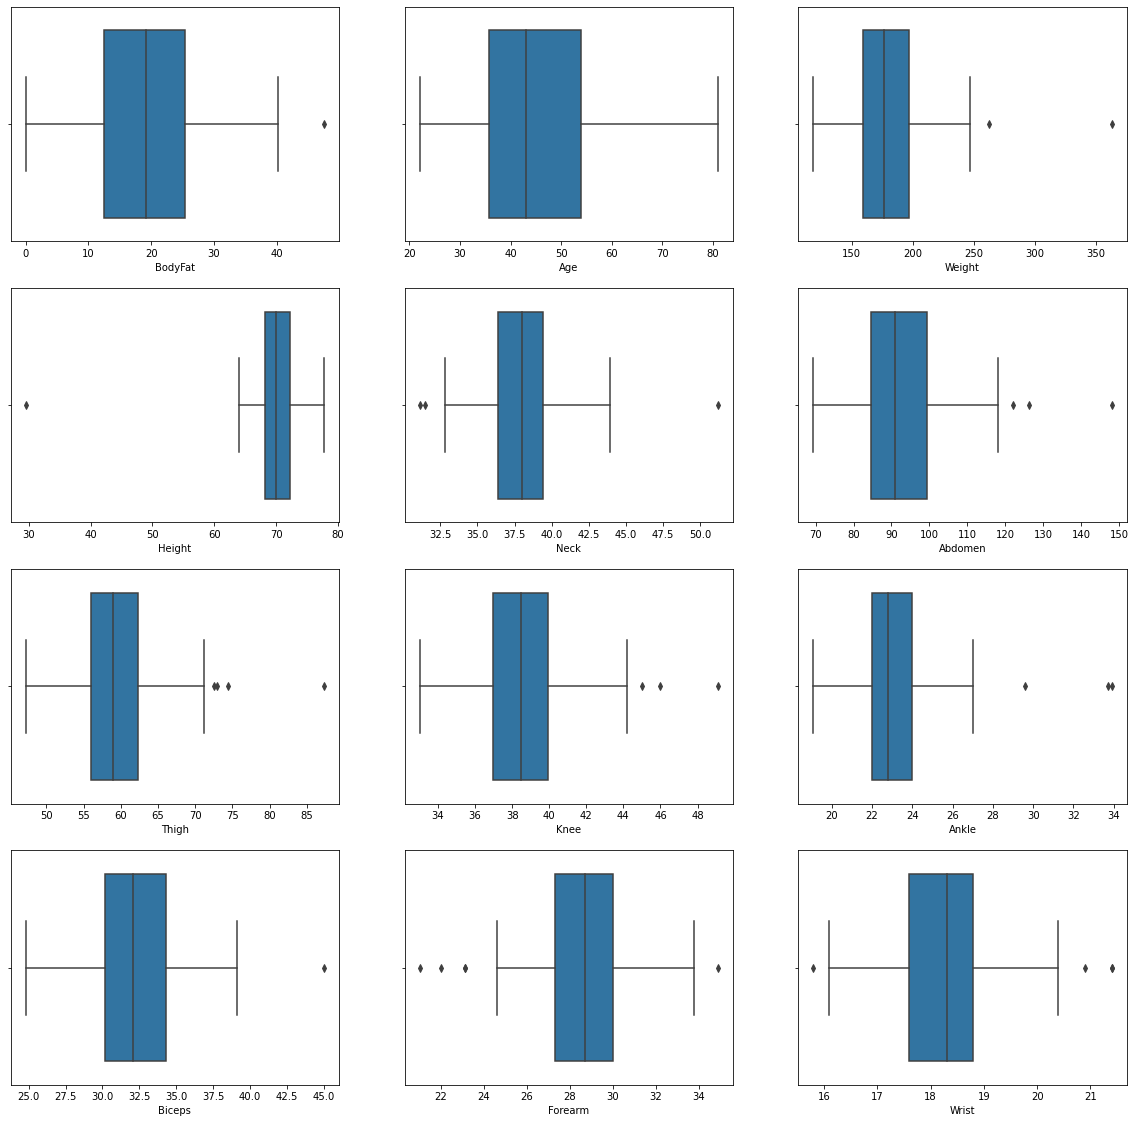

In [108]:
plt.figure(figsize=(20,25))

for col, n in zip(df.columns, range(1,16)):
    plt.subplot(5, 3, n)
    sns.boxplot(data=df, x=col)
            
plt.show()

In [109]:
def replace_outliers(df, columns):
  for col in columns:
    # calculating Q1 and Q3
    Q1 = df.loc[:,col].quantile(0.25)
    Q3 = df.loc[:,col].quantile(0.75)
    
    # calculating Interquartile IQR
    IQR = Q3 - Q1
    
    # build up filter
    filter_up = (df.loc[:,col] > Q3 + 1.5 * IQR)
    
    # apply up filter on df
    df.loc[filter_up, col] = Q3 + 1.5 * IQR
    
    # build down filter
    filter_down = (df.loc[:,col] < Q1 - 1.5 * IQR)
    
    # apply down filter on df
    df.loc[filter_down, col] = Q1 - 1.5 * IQR

In [110]:
df_out = df.copy()
columns = list(df.drop(columns='BodyFat').columns)

In [111]:
replace_outliers(df_out, columns)

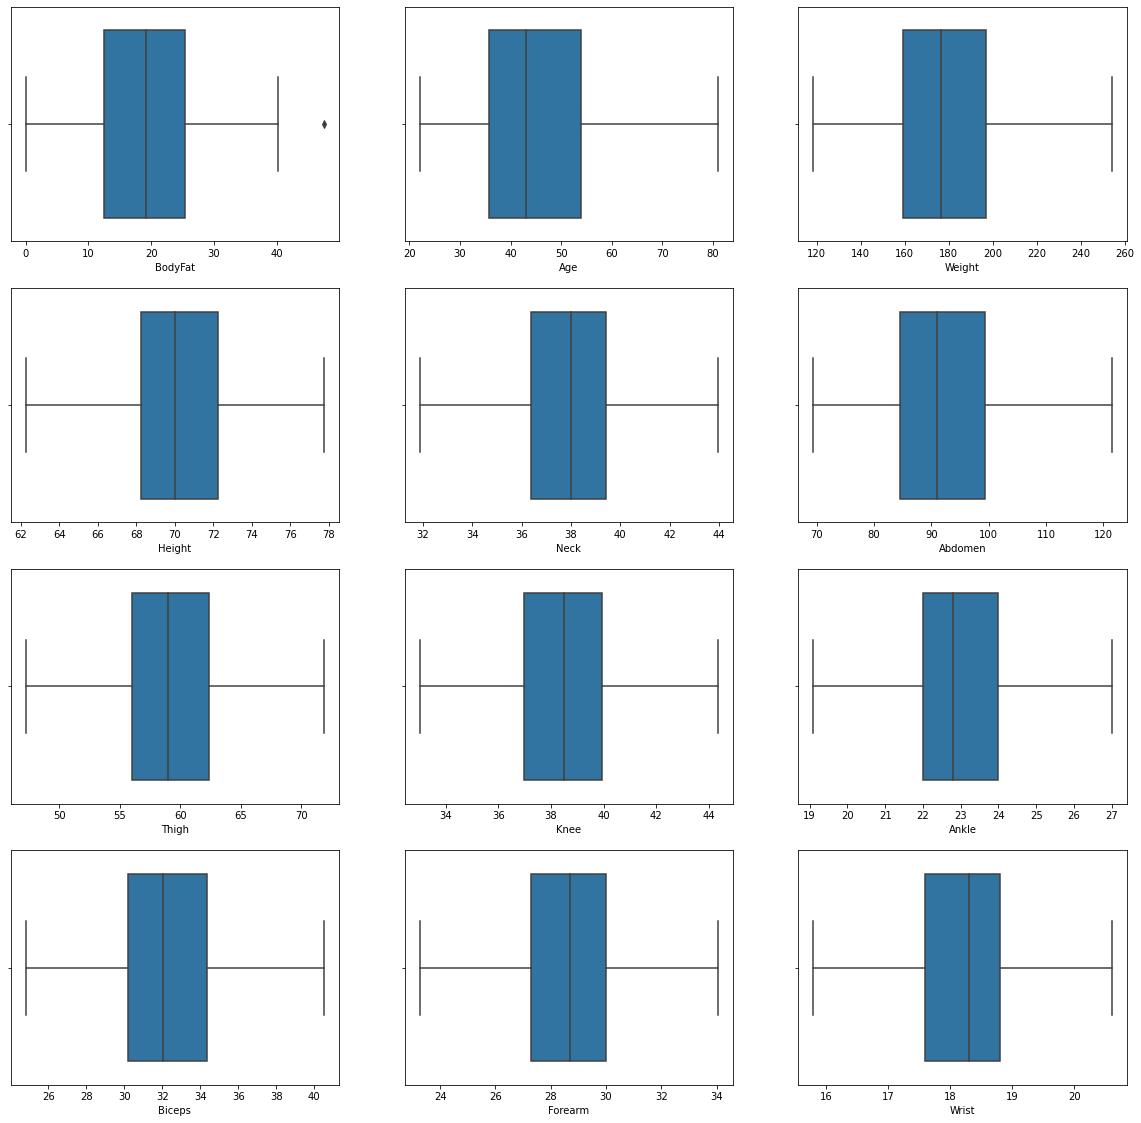

In [112]:
cols = list(df_out.columns)

plt.figure(figsize=(20,25))

for col, n in zip(df_out.columns, range(1,16)):
    plt.subplot(5, 3, n)
    sns.boxplot(data=df_out, x=col)
            
plt.show()

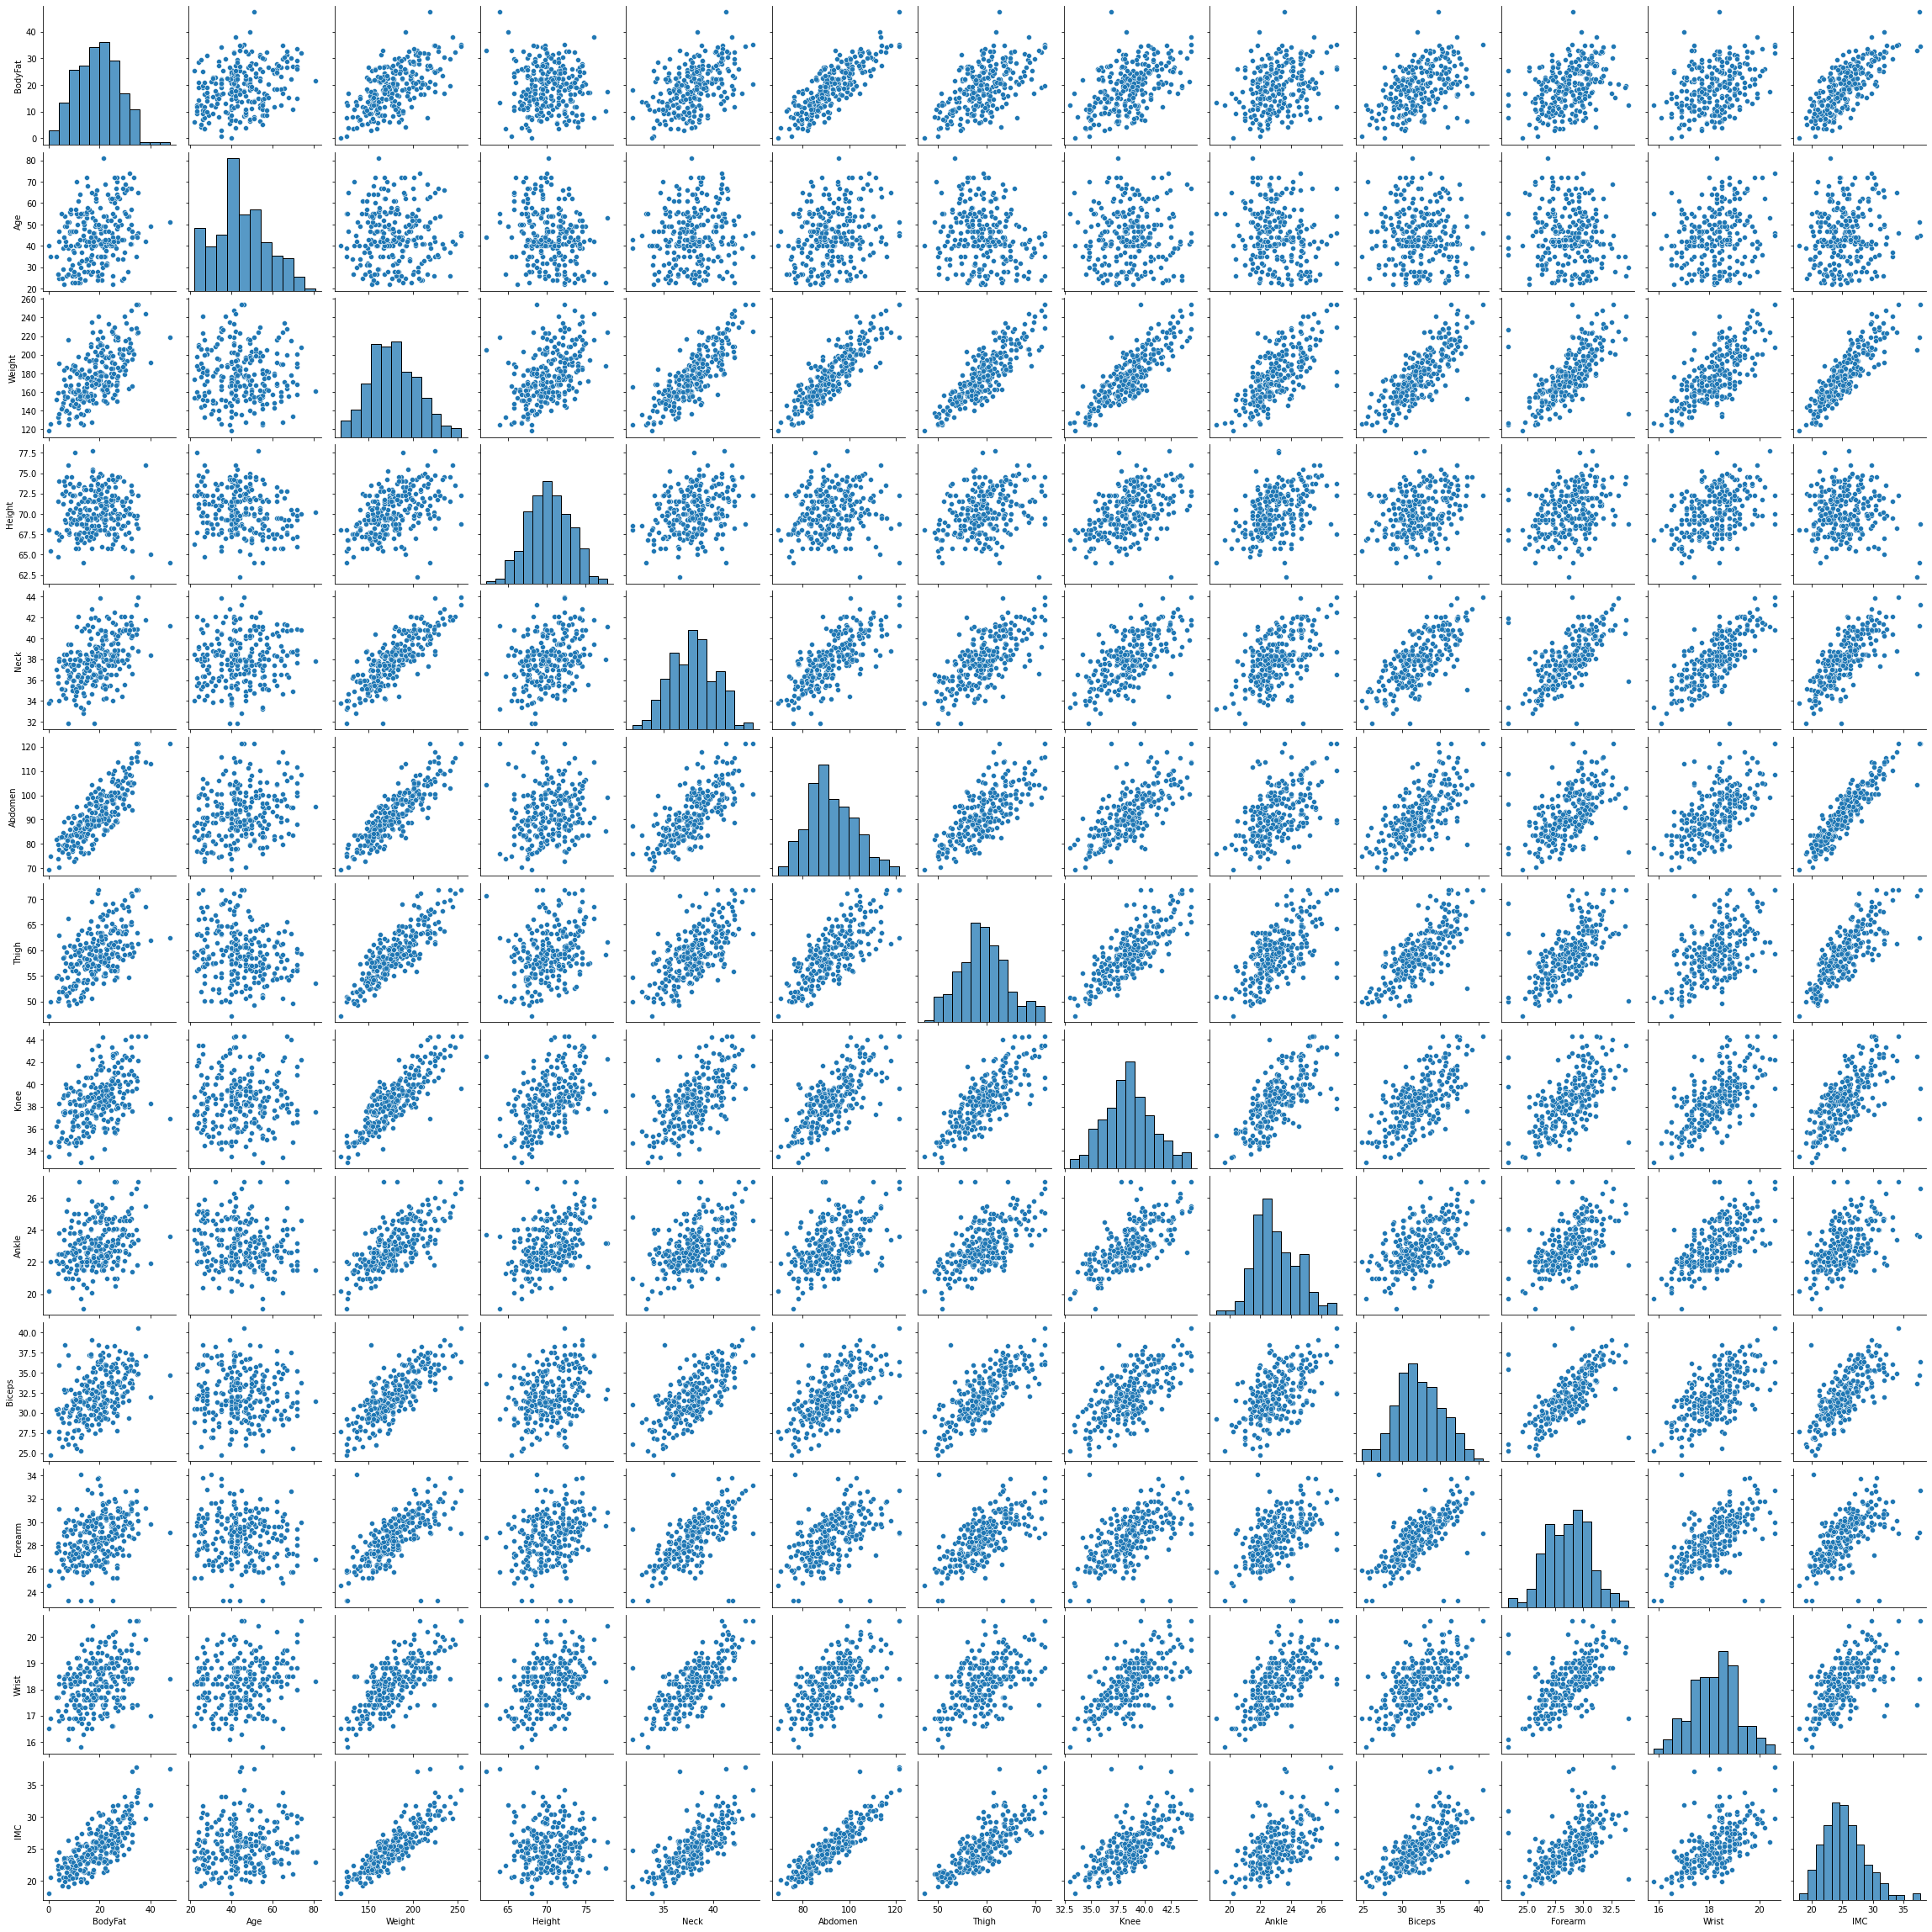

In [132]:
sns.pairplot(df_out)

### Dividir o dataset

In [113]:
y = df['BodyFat']
x = df.drop(columns=['BodyFat'])

In [114]:
x_Train, x_Test, y_Train, y_Test = train_test_split(x, y, test_size=0.2, random_state=42)

data = (x_Train, x_Test, y_Train, y_Test)

for d in data:
    d.reset_index(drop=True, inplace=True)

In [115]:
x_out = df_out.drop(columns=['BodyFat'])

In [116]:
x_Train_out, x_Test_out, y_Train, y_Test = train_test_split(x_out, y, test_size=0.2, random_state=42)

data = (x_Train_out, x_Test_out, y_Train, y_Test)

for d in data:
    d.reset_index(drop=True, inplace=True)

### Treinamento e validação de modelos

In [117]:
reg = LinearRegression().fit(x_Train, y_Train)
y_pred = reg.predict(x_Test)
predLinear = predict_table(y_Test, y_pred, residual=True)
adj_quality(predLinear[['Real', 'Previsto']], index='Não tratados')

,R²,MSE,RMSE,RMSLE,MAE
Não tratados,0.635,16.963,4.119,0.058,3.314


In [118]:
reg_out = LinearRegression().fit(x_Train_out, y_Train)
y_pred_out = reg_out.predict(x_Test_out)
predLinear_out = predict_table(y_Test, y_pred_out, residual=True)
adj_quality(predLinear_out[['Real', 'Previsto']], index='Remoção de Outliers')

,R²,MSE,RMSE,RMSLE,MAE
Remoção de Outliers,0.732,12.456,3.529,0.054,2.983


### Análise de resíduos

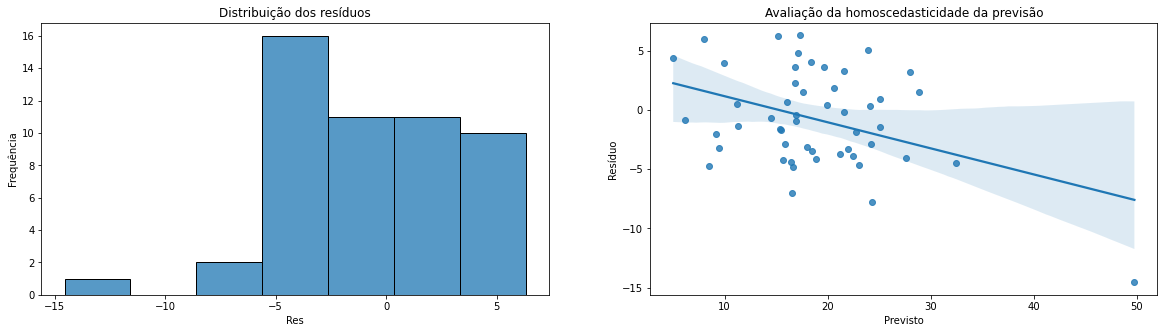

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

sns.histplot(data=predLinear, x='Res', ax=axes[0]).set_ylabel('Frequência')
axes[0].set_title('Distribuição dos resíduos')

sns.regplot(data=predLinear, x='Previsto', y='Res', ax=axes[1]).set_ylabel('Resíduo')
axes[1].set_title('Avaliação da homoscedasticidade da previsão')

plt.show()

In [122]:
np.var(predLinear['Res'], ddof=1)

16.710949971812674

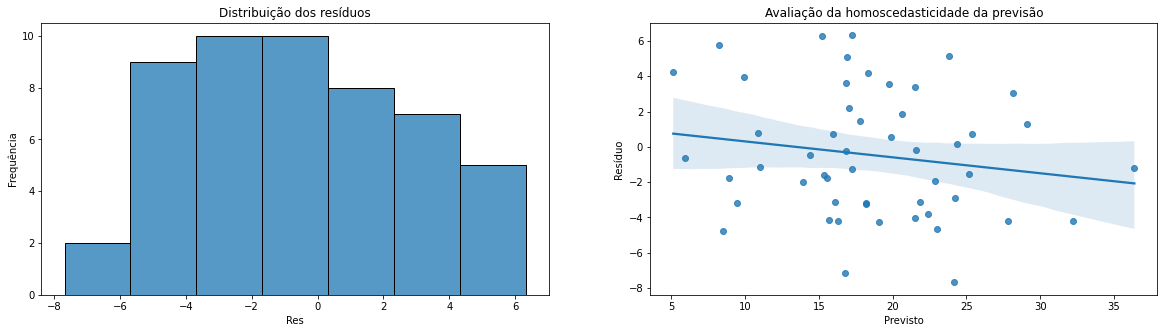

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

sns.histplot(data=predLinear_out, x='Res', ax=axes[0]).set_ylabel('Frequência')
axes[0].set_title('Distribuição dos resíduos')

sns.regplot(data=predLinear_out, x='Previsto', y='Res', ax=axes[1]).set_ylabel('Resíduo')
axes[1].set_title('Avaliação da homoscedasticidade da previsão')

plt.show()

In [121]:
np.var(predLinear_out['Res'], ddof=1)

12.491184305366184

### Converter para kg e cm para calcular o IMC

In [127]:
df_out.head()

,BodyFat,Age,Weight,Height,Neck,Abdomen,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,IMC
0,12.3,23.0,154.25,67.75,36.2,85.2,59.0,37.3,21.9,32.0,27.4,17.1,23.627041
1,6.1,22.0,173.25,72.25,38.5,83.0,58.7,37.3,23.4,30.5,28.9,18.2,23.334597
2,25.3,22.0,154.00,66.25,34.0,87.9,59.6,38.9,24.0,28.8,25.2,16.6,24.669010
3,10.4,26.0,184.75,72.25,37.4,86.4,60.1,37.3,22.8,32.4,29.4,18.2,24.883502
4,28.7,24.0,184.25,71.25,34.4,100.0,63.2,42.2,24.0,32.2,27.7,17.7,25.517641


In [126]:
df_out['IMC'] = (df_out['Weight'] / 2.2046) / np.power((df_out['Height'] * 0.0254), 2)

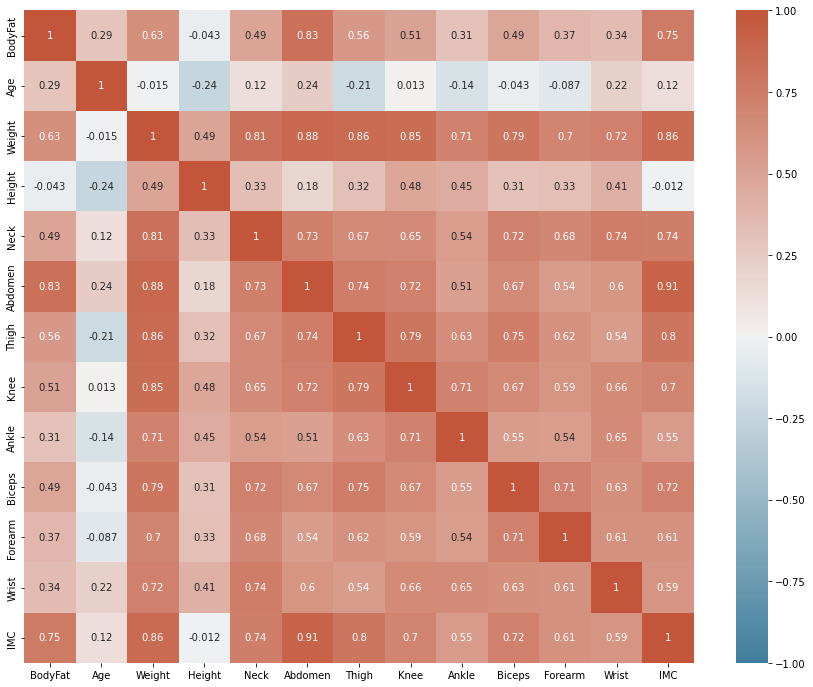

In [128]:
corrplot(df_out, figsize=(15,12))

In [129]:
x_imc = df_out.drop(columns=['BodyFat', 'Height'])

In [130]:
x_Train_imc, x_Test_imc, y_Train, y_Test = train_test_split(x_imc, y, test_size=0.2, random_state=42)

data = (x_Train_imc, x_Test_imc, y_Train, y_Test)

for d in data:
    d.reset_index(drop=True, inplace=True)

In [131]:
reg_imc = LinearRegression().fit(x_Train_imc, y_Train)
y_pred_imc = reg_imc.predict(x_Test_imc)
predLinear_imc = predict_table(y_Test, y_pred_imc, residual=True)
adj_quality(predLinear_imc[['Real', 'Previsto']], index='Troca de Height por IMC')

,R²,MSE,RMSE,RMSLE,MAE
Troca de Height por IMC,0.734,12.351,3.514,0.053,2.979
